# Chapter 2. Repository Pattern

Known Bugs in the Book
- https://github.com/cosmicpython/code/issues/17

## Persisting Our Domain Model

In [18]:
!tree -I '__pycache__|build|images|plantuml*'

.
├── 02-repository-pattern.ipynb
├── app
│   ├── __init__.py
│   ├── models.py
│   └── tests
│       ├── __init__.py
│       └── test_models.py
└── requirements.txt

2 directories, 6 files


In [19]:
!pip install -r ./requirements.txt

In [20]:
!pytest

============================= test session starts ==============================
platform linux -- Python 3.9.1, pytest-6.1.2, py-1.9.0, pluggy-0.13.1
rootdir: /home/ykkim/notebooks/2021-msa-study/02-repository-pattern
collected 12 items                                                             

app/tests/test_models.py ............                                    [100%]

============================== 12 passed in 0.03s ==============================


In [25]:
!mypy --strict -m app.models

Success: no issues found in 1 source file


## Reminder: Our Model

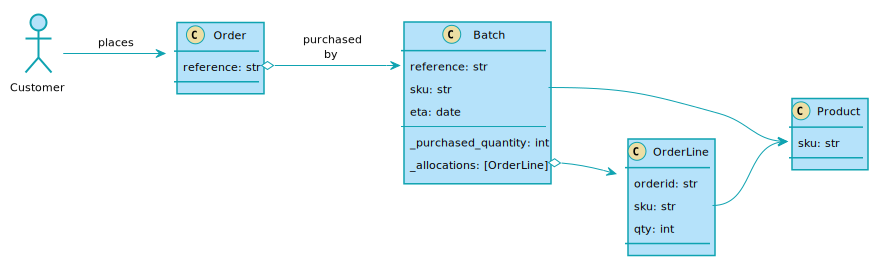

In [4]:
%%plantuml

@startuml

allow_mixing
left to right direction

class Product {
    sku: str
}

class Order {
    reference: str
}

class OrderLine {
    orderid: str
    sku: str
    qty: int
}

class Batch {
    reference: str
    sku: str
    eta: date
    --
    _purchased_quantity: int
    _allocations: [OrderLine]
}

actor Customer

Customer --> Order : places
Order::reference o--> Batch::reference : "purchased\nby"
Batch::_allocations o--> OrderLine
OrderLine::sku --> Product::sku
Batch::sku --> Product::sku

@enduml

#### Customers place *orders* for *products*.

- **Product**
  - identified by *SKU*(Stock Keeping Unit)
- **Order**
  - identified by an *order reference* 
  - comprises mutliple *order lines*
- **OrderLine**
  - has a *SKU* and a *quantity*
  
#### The purchasing department orders small *batches* of stock

- **Batch**
  - has a unique ID(*reference*), a *SKU*, and a *quantity* 
  - has an ETA if they are currently shipping
    - or they may be in *warehouse stock*.
  
##### We need to **allocate** *order lines* to *batches*.

- When we allocate x units of stock to a batch, the *available quantity* is reduced by x.

### The "Normal" ORM Way: Model Depends on ORM

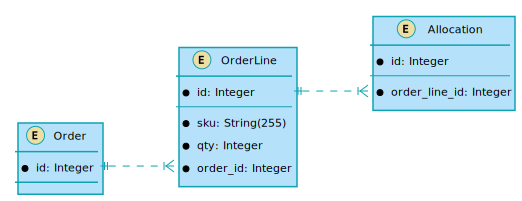

In [6]:
%%plantuml

@startuml

left to right direction

entity Order {
    * id: Integer
}

entity OrderLine {
    * id: Integer
    --
    * sku: String(255)
    * qty: Integer
    * order_id: Integer
}

entity Allocation {
    *id: Integer
    --
    * order_line_id: Integer
}

Order::id ||..|{ OrderLine::order_id
OrderLine::id ||..|{ Allocation::order_line_id 

@enduml

In [7]:
from sqlalchemy import Column, ForeignKey, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship

Base = declarative_base()

class Order(Base):
    __tablename__ = 'order'
    id = Column(Integer, primary_key=True, autoincrement=True)
    order_lines = relationship('OrderLine')
    
class OrderLine(Base):
    __tablename__ = 'order_line'
    id = Column(Integer, primary_key=True, autoincrement=True)
    sku = Column(String(255))
    qty = Column(Integer)
    order_id = Column(Integer, ForeignKey('order.id'))
    order = relationship(Order)
    allocations = relationship('Allocation')
    
class Allocation(Base):
    __tablename__ = 'allocation'
    id = Column(Integer, primary_key=True, autoincrement=True)
    order_line_id = Column(Integer, ForeignKey('order_line.id'))

########################################################################
    
import io, re, contextlib
from sqlalchemy import create_engine

out = io.StringIO()
with contextlib.redirect_stdout(out):
    engine = create_engine('sqlite://', echo=True) # temporary memory db
    Base.metadata.create_all(engine)

print(''.join(re.findall('CREATE TABLE.*?\n\n', out.getvalue(), re.DOTALL)))    

CREATE TABLE "order" (
	id INTEGER NOT NULL, 
	PRIMARY KEY (id)
)

CREATE TABLE order_line (
	id INTEGER NOT NULL, 
	sku VARCHAR(255), 
	qty INTEGER, 
	order_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(order_id) REFERENCES "order" (id)
)

CREATE TABLE allocation (
	id INTEGER NOT NULL, 
	order_line_id INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(order_line_id) REFERENCES order_line (id)
)




### Inverting the Dependency: ORM Depends on Model

Using SQLAlchemy's "classical mapping".

In [8]:
from sqlalchemy import MetaData, Table, Column, ForeignKey, Integer, String, Date
from sqlalchemy.orm import mapper
from app import models

metadata = MetaData()

order_line = Table(
    'order_line', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('sku', String(255)),
    Column('qty', Integer, nullable=False),
    Column('orderid', String(255)),
    extend_existing=True
)
order_line_mapper = mapper(models.OrderLine, order_line)

In [9]:
from typing import Callable
from contextlib import contextmanager, AbstractContextManager

from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm.session import Session

engine = create_engine('sqlite://') # temporary memory db
metadata.create_all(engine)

SqliteSessionMaker = sessionmaker(engine)
SessionFactory = AbstractContextManager[Session]

@contextmanager
def session() -> SessionFactory:
    '''`with session` 블록을 이용한 자동 리소스 반환을 구현합니다.'''
    session = SqliteSessionMaker()
    try:
        yield session
    finally:
        session.close()

In [10]:
from app import mytest

mytest.init(__name__)

@mytest.unit
def test_orderline_mapper_can_load_lines(session):
    with session as db:
        db.execute('''
        INSERT INTO order_line (orderid, sku, qty) VALUES
        ('order1', 'RED-CHAIR', 12),
        ('order2', 'RED-TABLE', 13),
        ('order3', 'BLUE-LIPSTICK', 14)
        ''')
        expected = [
            models.OrderLine('order1', 'RED-CHAIR', 12),
            models.OrderLine('order2', 'RED-TABLE', 13),
            models.OrderLine('order3', 'BLUE-LIPSTICK', 14),
        ]
        assert expected == db.query(models.OrderLine).all()

✅ test_orderline_mapper_can_load_lines


In [11]:
@mytest.unit
def test_orderline_mapper_can_save_lines(session):
    with session as db:
        new_line = models.OrderLine('order1', 'DECORATIVE-WIDGET', 12)
        db.add(new_line)
        db.flush()
        
        rows = list(db.execute('SELECT orderid, sku, qty FROM order_line'))
        assert [('order1', 'DECORATIVE-WIDGET', 12)] == rows

✅ test_orderline_mapper_can_save_lines


## Introducing the Repository Pattern

- An abstraction over persistent storage. 
- Hides details of data access by *pretending that all of data is in memory*.

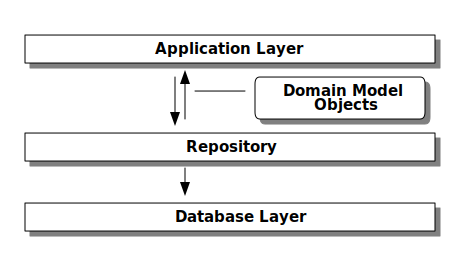

In [12]:
%%ditaa repository-pattern
+----------------------------------------+
|           Application Layer            |
+----------------------------------------+
               |^      /----------------\
               ||------|  Domain Model  |
               ||      |     Objects    |
               V|      \----------------/
+----------------------------------------+
|               Repository               |
+----------------------------------------+
                |
                V
+----------------------------------------+
|              Database Layer            |
+----------------------------------------+        

### The Repository in the Abstract

In [13]:
from typing import Protocol, Iterable, Set
import abc

class AbstractRepository(abc.ABC):

    @abc.abstractmethod
    def add(self, batch: models.Batch):
        raise NotImplementedError

    @abc.abstractmethod
    def get(self, reference) -> models.Batch:
        raise NotImplementedError
        
    @abc.abstractmethod
    def clear(self) -> None:
        raise NotImplementedError

# Alternative approache: using `Protocol`
class RepositoryProtocol(Protocol):
    def add(self, batch: models.Batch) -> None:
        pass

    def get(self, reference) -> models.Batch:
        pass
    
    def clear(self) -> None:
        pass

### What is the Trade-Off?

Introducing an extra layer of abstraction, 
- Will reduce complexity overall
- But add complexity locally

#### Repository test for saving an object

In [14]:
from typing import Optional, Callable

class SqlAlchemyRepository(AbstractRepository):
    def __init__(self, session: Callable[[], SessionFactory]):
        self.session = session
    
    def add(self, batch: models.Batch):
        with self.session() as db:
            db.add(batch)
            db.commit()

    def get(self, reference) -> Optional[models.Batch]:
        with self.session() as db:
            db.query(Batch).filter_by(reference=reference).first()
    
    def clear(self):
        with self.session() as db:
            db.execute('DELETE FROM batch')
            db.execute('DELETE FROM order_line')
            db.commit()

In [15]:
def repo():
    return SqlAlchemyRepository(session)

In [16]:
batch = Table(
    'batch', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('reference', String(255), unique=True),
    Column('_purchased_quantity', Integer),
    Column('sku', String(255)),
    Column('eta', Date, nullable=True),
    extend_existing=True
)

batch_mapper = mapper(models.Batch, batch)

In [16]:
@mytest.unit
def test_repository_can_save_a_batch(repo, session):
    batch = models.Batch("batch1", "RUSTY-SOAPDISH", 100, eta=None)
    repo.add(batch)
    with session as db:
        rows = list(db.execute(
            'SELECT reference, sku, _purchased_quantity, eta FROM "batch"'
        ))
        assert rows == [("batch1", "RUSTY-SOAPDISH", 100, None)]
    repo.clear()

✅ test_repository_can_save_a_batch


In [ ]:
def insert_order_line(db):
    db.execute(
        'INSERT INTO order_lines (orderid, sku, qty)'
        ' VALUES ("order1", "GENERIC-SOFA", 12)'
    )
    [[orderline_id]] = session.execute(
        'SELECT id FROM order_lines WHERE orderid=:orderid AND sku=:sku',
        dict(orderid="order1", sku="GENERIC-SOFA")
    )
    return orderline_id


def insert_batch(db, reference):
    db.execute(
        'INSERT INTO batch (reference, sku, qty)'
        f' VALUES ("{reference}", "GENERIC-SOFA", 12)'
    )
    [[batch_id]] = session.execute(
        'SELECT id FROM batch WHERE reference=:reference',
        dict(reference=reference)
    )
    return batch_id


def insert_allocation(db, reference):
    db.execute(
        'INSERT INTO batch(reference, sku, qty)'
        f' VALUES ("{reference}", "GENERIC-SOFA", 12)'
    )
    [[batch_id]] = session.execute(
        'SELECT id FROM batch WHERE reference=:reference',
        dict(reference=reference)
    )
    return batch_id

@mytest.unit
def test_repository_can_retrieve_a_batch_with_allocations(repo, session):
    with session as db:
        orderline_id = insert_order_line(db)
        batch1_id = insert_batch(db, "batch1")
        insert_batch(session, "batch2")
        insert_allocation(session, orderline_id, batch1_id)

    retrieved = repo.get("batch1")
    expected = model.Batch("batch1", "GENERIC-SOFA", 100, eta=None)
    
    assert retrieved == expected  # Batch.__eq__ only compares reference  3
    assert retrieved.sku == expected.sku
    assert retrieved._purchased_quantity == expected._purchased_quantity
    assert retrieved._allocations == {
        model.OrderLine("order1", "GENERIC-SOFA", 12),
    }

## Building a Fake Repository for Tests is Now Trivial!

## What is a Port and What is an Adapter, in Python?

## Wrap-Up